Задача 2
Чем активнее наши пользователи – тем выше нагрузка на сервера. И в последнее время нам всё чаще приходят жалобы, что приложение подвисает. Звучит как задача для девопсов и инженеров!

От вас тоже попросили внести свой вклад в задачу – спрогнозировать, как изменится активность пользователей в течение ближайшего месяца. Давайте попробуем это сделать!

Выберите основную метрику, которую вы планируете прогнозировать. Обоснуйте, почему именно она. Какое временное разрешение вы возьмёте? Будут ли какие-то дополнительные регрессоры, которые вы включите в модель?
Постройте модель и провалидируйте её. Хватает ли у нас данных для бэккастинга с текущей задачей? Если нет, то определите, для какого горизонта прогнозирования у нас хватает данных.
Выберите ту модель, которая кажется вам наиболее удачной (обоснуйте выбор). Проинтерпретируйте её результаты. Если видите какие-то важные ограничения по выводу – не забудьте их тоже указать.

* Нагрузка на сервера обусловлена количеством активных пользователей приложения в день, поэтому в качестве метрики возьмем DAU из пользователей ленты новостей и мессенджера. 
* У нас есть данные о пользователях с 03.06.23, то есть за 9 недель. Паттерн сезонности составляет неделю. Для тестирования прогноза модели следует разбить имеющиемя данные на тренировочную и тестовую выборки в соотношении 70%/30% или 80%/20%. В нешем случае это составит train = 6 недель, test = 3 недели или train = 7 недель, test = 2 недели.Таким образом, чтобы сделать прогноз на месяц вперед и протестировать моедль, у нас недостаточно данных. 
* Для беккастинга с прогнозом на месяц у нас не хвататет данных ( сможем сделать не более двух итераций). Для прогноза на неделю беккастинг можно попробовать выполнить.
* Информации о регрессорах, значения которых мы заранее знаем на следующий месяц, у нас нет, поэтому не будем их использовать.

In [2]:
import pandas as pd
import pandahouse 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from causalimpact import CausalImpact

2023-08-07 07:15:33.731345: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 07:15:34.346518: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 07:15:34.349276: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 07:15:36.846904: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import orbit #общий пакет
from orbit.models import DLT #один из вариантов модели
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #для рисования предсказаний
from orbit.diagnostics.metrics import rmsse

#общие штуки для кручения данных
import os

#общие штуки для рисования
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az #это полезно для визуализации MCMC

In [365]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': '****',,
    'user': '****',,
    'database': 'simulator_20230720'
}
#=================================================================
q = """
select count(DISTINCT users) as users,
       date
from 
    (SELECT  DISTINCT user_id as users,
             toDate(time) date
    FROM simulator_20230720.feed_actions 
    where toDate(time) < today() ) fa
full join 
    (SELECT  DISTINCT user_id as users,
             toDate(time) date
    FROM simulator_20230720.message_actions 
    where toDate(time) < today() ) ma
using date
GROUP by date
order by date
"""
dau_df = pandahouse.read_clickhouse(q, connection=connection)
dau_date_df = dau_df.set_index('date')

In [5]:
import datetime
from datetime import datetime

In [366]:
dau_date_df.head(5)

,users
date,
2023-06-03,878
2023-06-04,2238
2023-06-05,3105
2023-06-06,3721
2023-06-07,4617


## Алгоритм работы
* Для выбора модели разобьем данные на тренировочные и тестовые в соотношении 7 недель / 3 недели. Для теста берем не 4 недели (хотя прогноз нам надо будет делать на 4 недели в итоге), а 3, чтобы тренироваться на бОльшей выборке.
* Выберем более точную модель по метрике RMSE (корень среднекадратического отклонения).
* Выбранной моделью сделаем прогноз на 4 недели вперед.
* Обратим внимание на два выброса в данных (скачок 13.07 и падение 22.07). Загладим их для финальной модели, заменив осреднением по соседним дням. Построим прогноз без выбросов.

In [367]:
dau_train = dau_df.query("date <= '2023-07-16'")
dau_test = dau_df.query("date > '2023-07-16'")

2023-08-07 13:00:09 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following fa

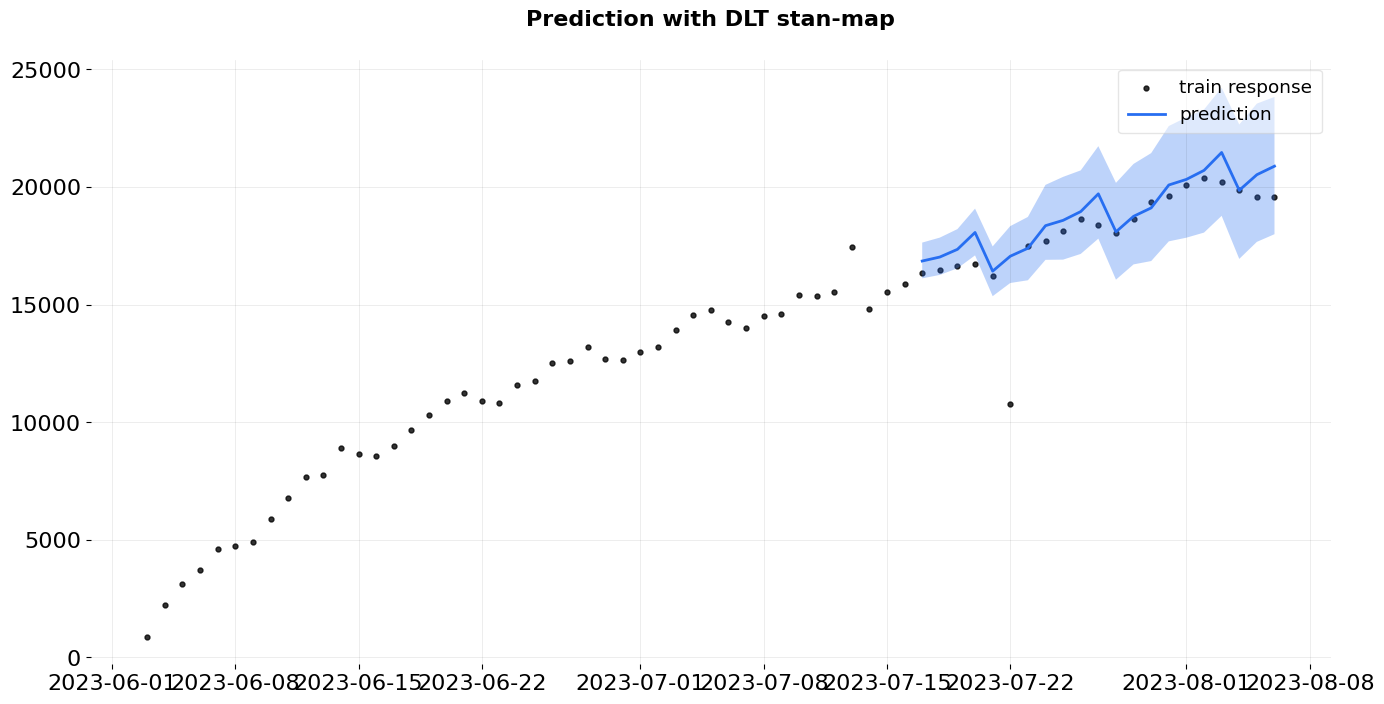

In [368]:
dlt = DLT(response_col="users", 
          date_col="date", 
          seasonality=7, 
          estimator="stan-map", 
          n_bootstrap_draws=1000) 

dlt.fit(dau_train)
#future_df = dlt.make_future_df(periods=7*4)
predict_dlt = dlt.predict(df=dau_test,
                         decompose=True)
_ = plot_predicted_data(dau_df, predict_dlt, "date", 'users', title='Prediction with DLT stan-map')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

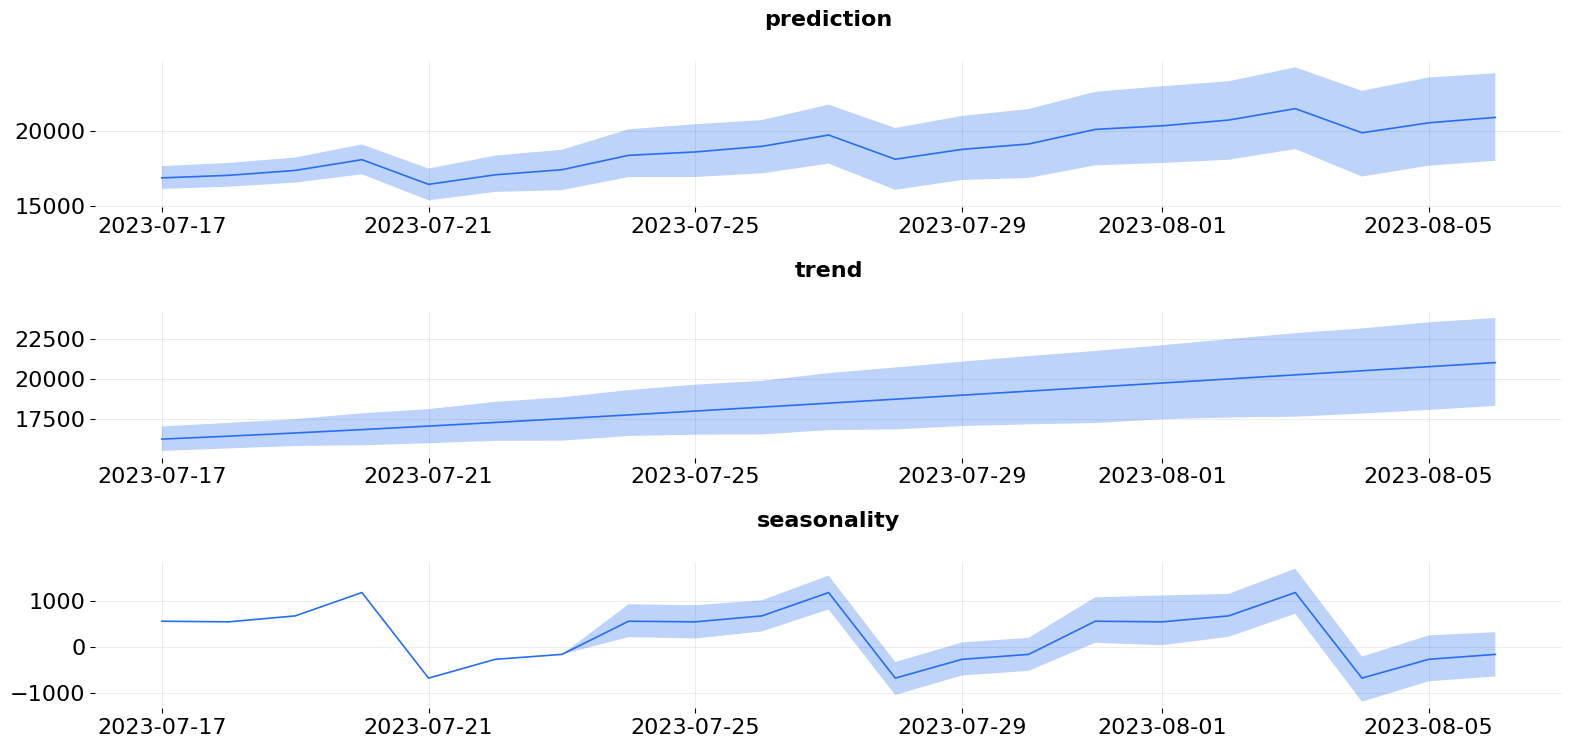

In [369]:
_ = plot_predicted_components(predict_dlt, "date", plot_components=['prediction', 'trend', 'seasonality'])

Предсказание на 3 недели довольно хорошо ложится на наши данные.

## Загладим выбросы и повторим предсказание

In [370]:
dau_smooth = dau_date_df.copy()
print(dau_smooth.loc['2023-07-13'].users)
dau_smooth.loc['2023-07-13'].users = (int(dau_smooth.loc['2023-07-12'][0]) + int(dau_smooth.loc['2023-07-14'][0])) // 2
print(dau_smooth.loc['2023-07-13'].users)
print(dau_smooth.loc['2023-07-22'].users)
dau_smooth.loc['2023-07-22'].users = (int(dau_smooth.loc['2023-07-21'][0]) + int(dau_smooth.loc['2023-07-23'][0])) // 2
print(dau_smooth.loc['2023-07-22'].users)

17452
15189
10754
16852


In [371]:
dau_smooth['date'] = dau_smooth.index
dau_smooth_train = dau_smooth.query("date <= '2023-07-16'")
dau_smooth_test = dau_smooth.query("date > '2023-07-16'")

2023-08-07 13:00:21 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following fa

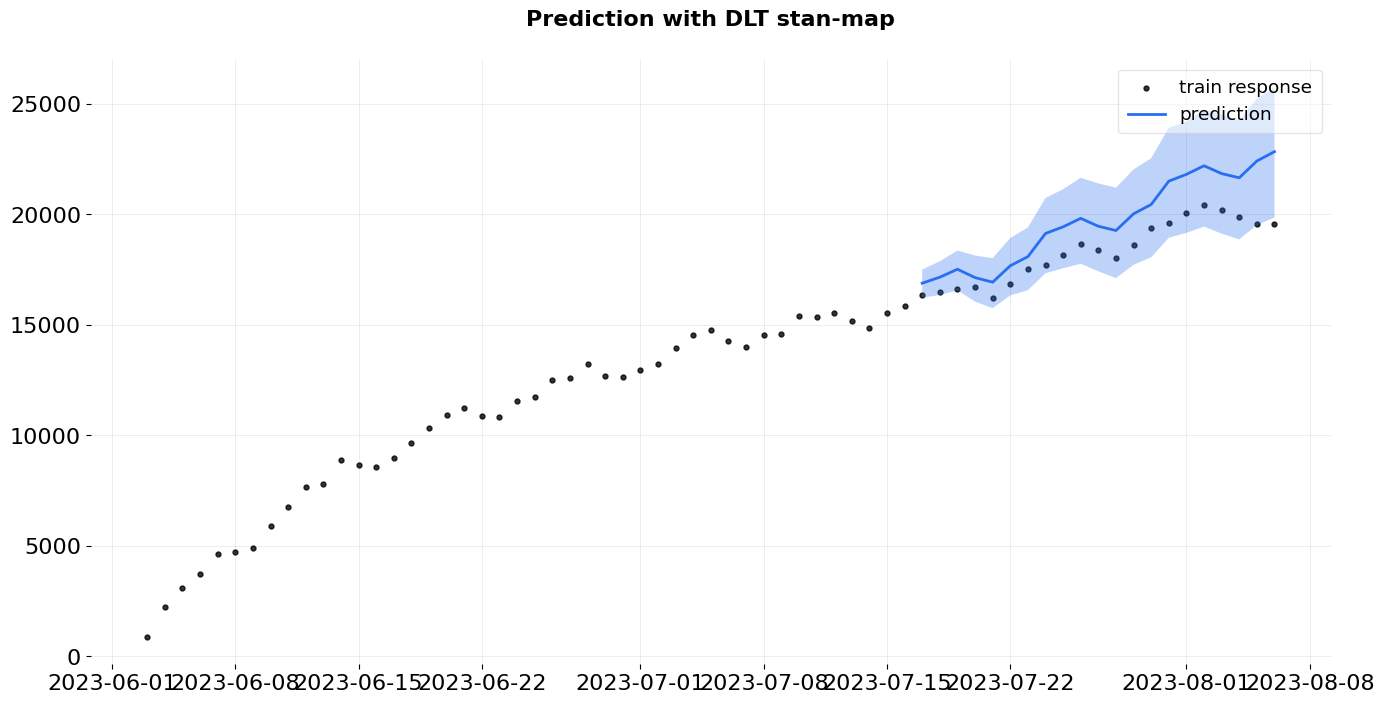

In [372]:
dlt_smooth = DLT(response_col="users", 
          date_col="date", 
          seasonality=7, 
          estimator="stan-map", 
          n_bootstrap_draws=1000) 

dlt_smooth.fit(dau_smooth_train)
predict_dlt_smooth = dlt_smooth.predict(df=dau_smooth_test)
_ = plot_predicted_data(dau_smooth, predict_dlt_smooth, "date", 'users', title='Prediction with DLT stan-map')

На данных без выбросов прогноз стал выше, чем истинные значения. Истинные данные лежат на нижней границе доверительного интервала.

Сопоставим модель с выбросами и модель без выбросов по метрике RMSE

In [373]:
print(f"RMSE map: {rmsse(dau_test.users.values, predict_dlt.prediction.values, dau_train.users.values)}")
print(f"RMSE map smoothed: {rmsse(dau_smooth_test.users.values, predict_dlt_smooth.prediction.values, dau_smooth_train.users.values)}")

RMSE map: 0.7819589424079431
RMSE map smoothed: 3.688515370572764


Видим, что ошибка модели с выбросами меньше.

## Построим модель MCMC

2023-08-07 13:00:30 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 750 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

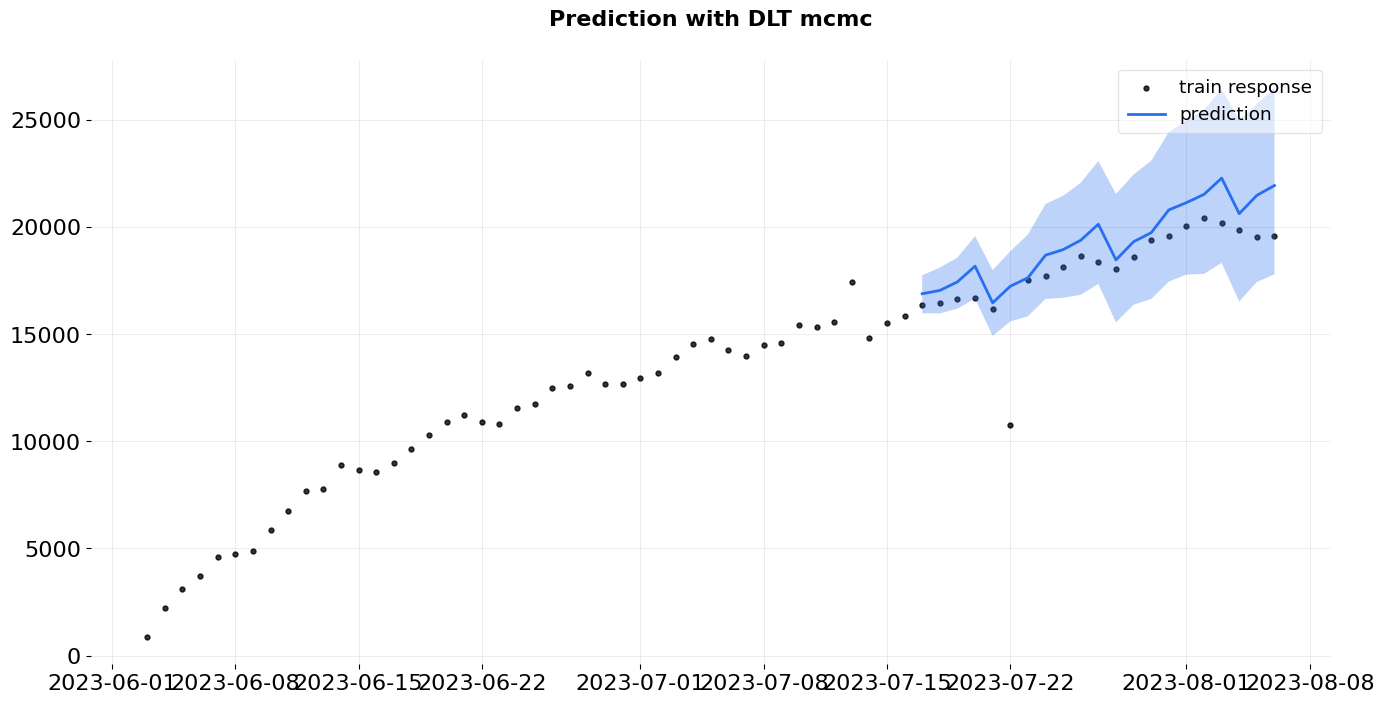

In [374]:
dlt_mcmc = DLT(seasonality=7, 
               response_col="users", 
               date_col="date", 
               estimator='stan-mcmc', 
               num_warmup=3000, 
               num_sample=1000) 

dlt_mcmc.fit(dau_train)
predict_mcmc = dlt_mcmc.predict(dau_test,
                               decompose=True)

_ = plot_predicted_data(dau_df, predict_mcmc, "date", "users", title='Prediction with DLT mcmc')

In [375]:
params = dlt_mcmc.get_posterior_samples(permute=False) #достаём информацию о параметрах

params.keys()

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 's', 'sea_sm', 'gt_sum', 'gb', 'gl', 'loglk'])

In [376]:
params["obs_sigma"].shape #лучше смотреть те, у которых третьего измерения либо нет, либо оно равно 1

(4, 250)

array([[<Axes: title={'center': 'obs_sigma'}>,
        <Axes: title={'center': 'obs_sigma'}>]], dtype=object)

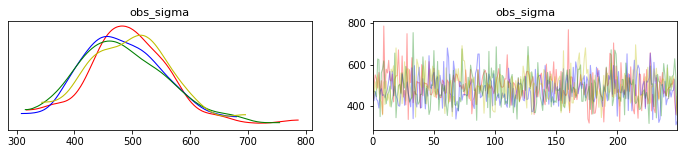

In [377]:
az.plot_trace(params, chain_prop={"color": ['r', 'b', 'g', 'y']}, var_names = "obs_sigma")

In [207]:
#_ = plot_predicted_components(predict_mcmc, "date", plot_components=['prediction', 'trend', 'seasonality'])

2023-08-07 13:02:08 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 750 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

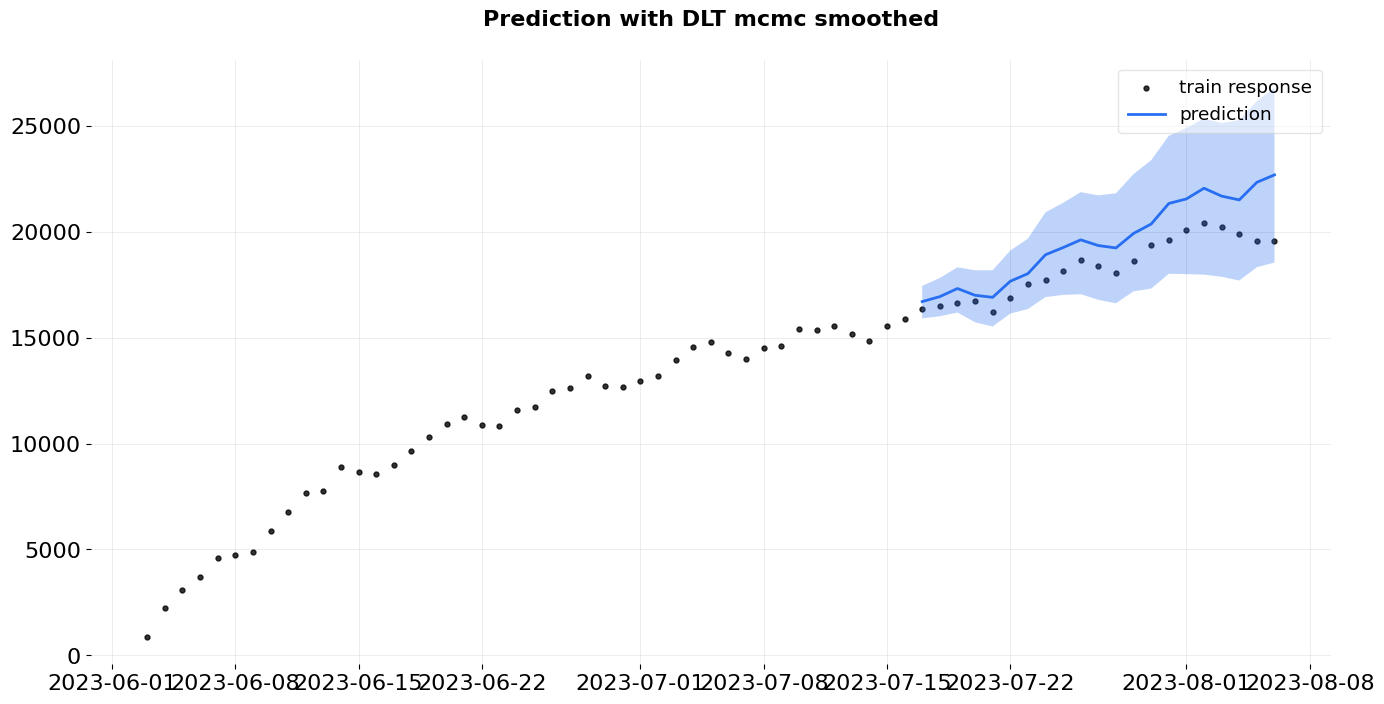

In [378]:
dlt_smooth_mcmc = DLT(seasonality=7, 
               response_col="users", 
               date_col="date", 
               estimator='stan-mcmc', 
               num_warmup=3000, 
               num_sample=1000) 

dlt_smooth_mcmc.fit(dau_smooth_train)
predict_smooth_mcmc = dlt_smooth_mcmc.predict(dau_smooth_test,
                               decompose=True)

_ = plot_predicted_data(dau_smooth, predict_smooth_mcmc, "date", "users", title='Prediction with DLT mcmc smoothed')

## Посмотрим на RMSE всех моделей

In [379]:
print(f"RMSE map: {rmsse(dau_test.users.values, predict_dlt.prediction.values, dau_train.users.values)}")
print(f"RMSE map smoothed: {rmsse(dau_smooth_test.users.values, predict_dlt_smooth.prediction.values, dau_smooth_train.users.values)}")
print(f"RMSE smooth mcmc: {rmsse(dau_smooth_test.users.values, predict_smooth_mcmc.prediction.values, dau_smooth_train.users.values)}")
print(f"RMSE mcmc: {rmsse(dau_test.users.values, predict_mcmc.prediction.values, dau_train.users.values)}")

RMSE map: 0.7819589424079431
RMSE map smoothed: 3.688515370572764
RMSE smooth mcmc: 3.390041132289302
RMSE mcmc: 0.9230678515684005


* Минимальную ошибку дает модель dlt с оценщиком stan-map

## Провалидируем все модели и на 4 неделях в качестве теста:

2023-08-07 13:02:53 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following fa

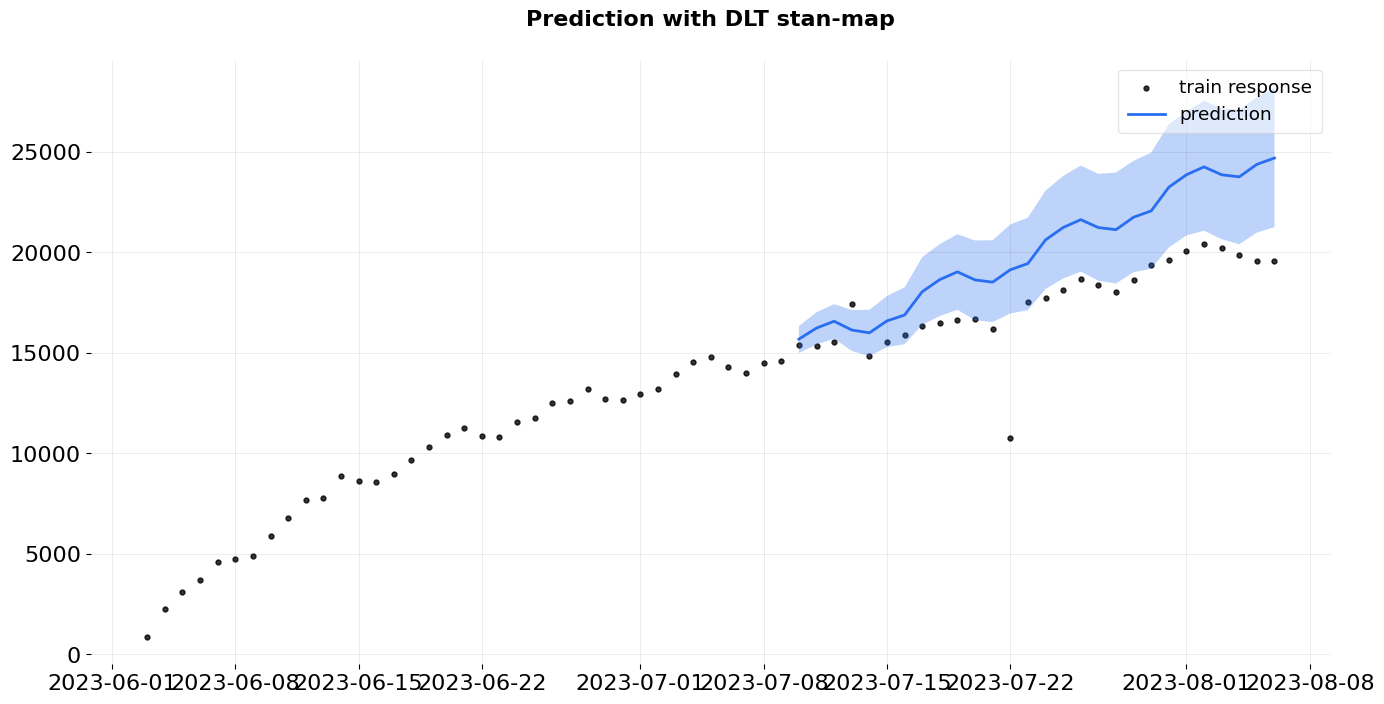

In [380]:
dau_train = dau_df.query("date <= '2023-07-09'")
dau_test = dau_df.query("date > '2023-07-09'")

dlt = DLT(response_col="users", 
          date_col="date", 
          seasonality=7, 
          estimator="stan-map", 
          n_bootstrap_draws=2000) 

dlt.fit(dau_train)
#future_df = dlt.make_future_df(periods=7*4)
predict_dlt = dlt.predict(df=dau_test,
                         decompose=True)
_ = plot_predicted_data(dau_df, predict_dlt, "date", 'users', title='Prediction with DLT stan-map')

2023-08-07 13:02:58 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following fa

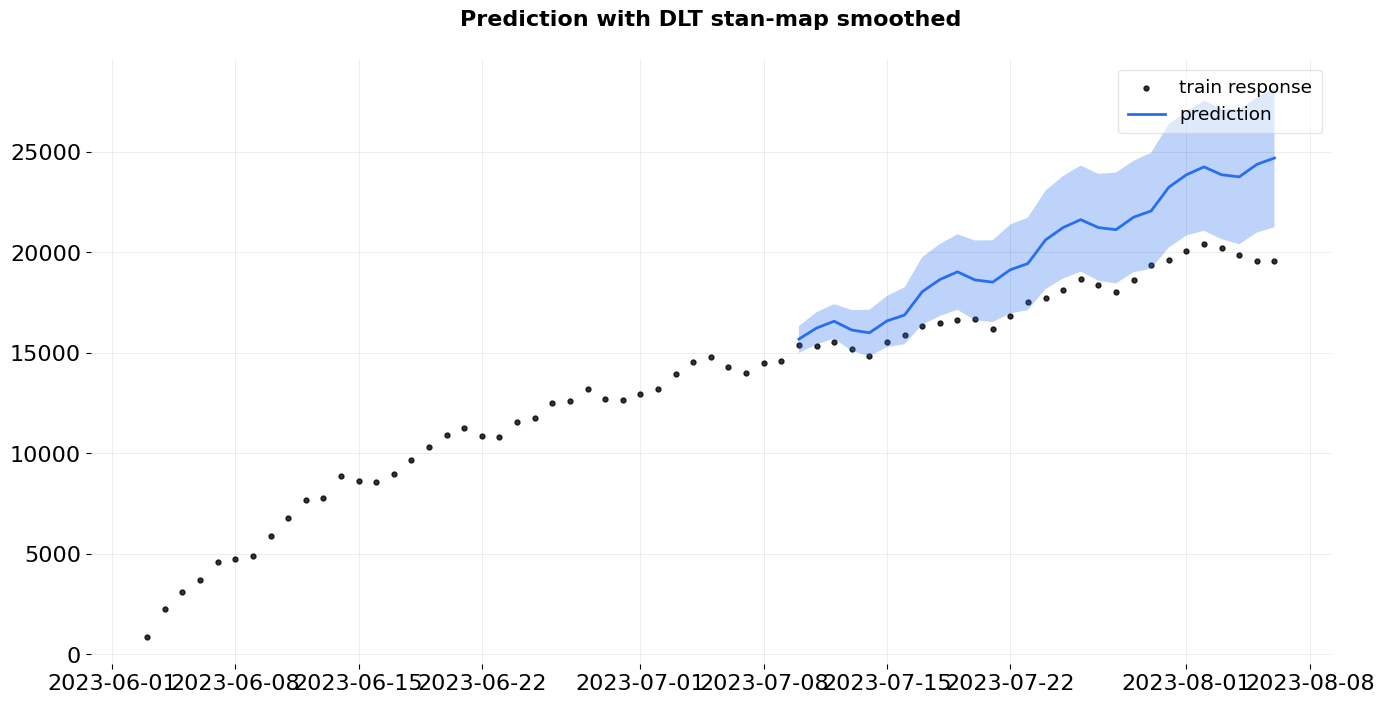

In [381]:
dau_smooth['date'] = dau_smooth.index
dau_smooth_train = dau_smooth.query("date <= '2023-07-09'")
dau_smooth_test = dau_smooth.query("date > '2023-07-09'")

dlt_smooth = DLT(response_col="users", 
          date_col="date", 
          seasonality=7, 
          estimator="stan-map", 
          n_bootstrap_draws=2000) 

dlt_smooth.fit(dau_smooth_train)
#future_df = dlt.make_future_df(periods=7*4)
predict_dlt_smooth = dlt_smooth.predict(df=dau_smooth_test,
                                         decompose=True)
_ = plot_predicted_data(dau_smooth, predict_dlt_smooth, "date", 'users', title='Prediction with DLT stan-map smoothed')

2023-08-07 13:03:02 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 750 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

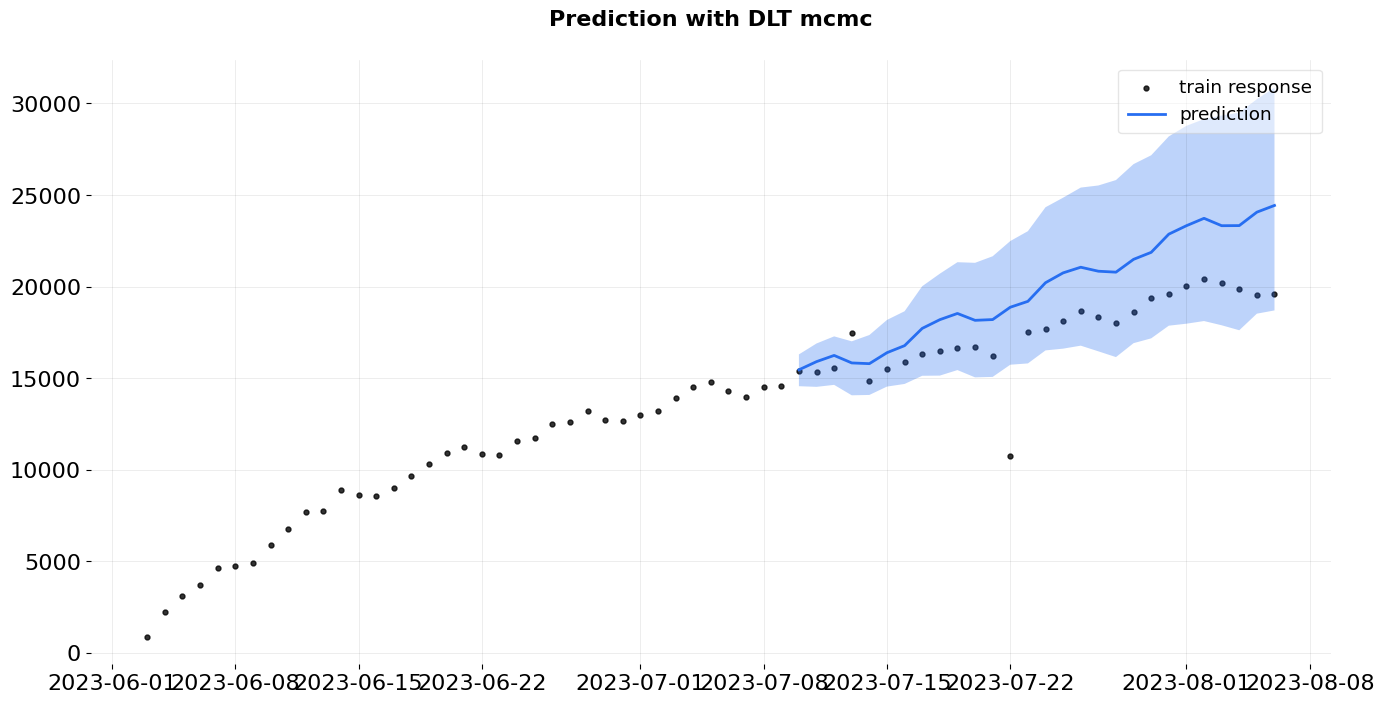

In [382]:
dlt_mcmc = DLT(seasonality=7, 
               response_col="users", 
               date_col="date", 
               estimator='stan-mcmc', 
               num_warmup=3000, 
               num_sample=1000) 

dlt_mcmc.fit(dau_train)
predict_mcmc = dlt_mcmc.predict(dau_test,
                               decompose=True)

_ = plot_predicted_data(dau_df, predict_mcmc, "date", "users", title='Prediction with DLT mcmc')

2023-08-07 13:03:12 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 750 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

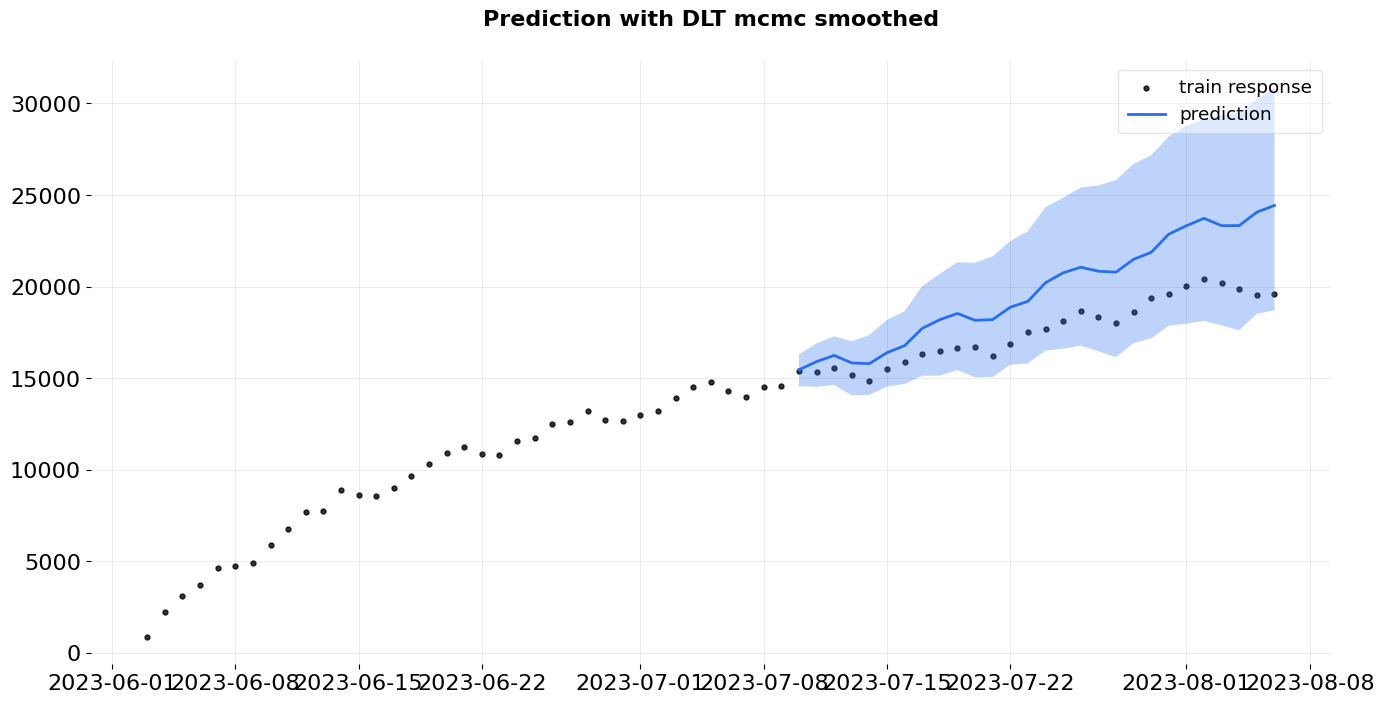

In [383]:
dlt_smooth_mcmc = DLT(seasonality=7, 
               response_col="users", 
               date_col="date", 
               estimator='stan-mcmc', 
               num_warmup=3000, 
               num_sample=1000) 

dlt_smooth_mcmc.fit(dau_smooth_train)
predict_smooth_mcmc = dlt_smooth_mcmc.predict(dau_smooth_test,
                               decompose=True)

_ = plot_predicted_data(dau_smooth, predict_smooth_mcmc, "date", "users", title='Prediction with DLT mcmc smoothed')

* Посмотрим на RMSE

In [384]:
print(f"RMSE map: {rmsse(dau_test.users.values, predict_dlt.prediction.values, dau_train.users.values)}")
print(f"RMSE map smoothed: {rmsse(dau_smooth_test.users.values, predict_dlt_smooth.prediction.values, dau_smooth_train.users.values)}")
print(f"RMSE mcmc smoothed: {rmsse(dau_smooth_test.users.values, predict_smooth_mcmc.prediction.values, dau_smooth_train.users.values)}")
print(f"RMSE mcmc: {rmsse(dau_test.users.values, predict_mcmc.prediction.values, dau_train.users.values)}")

RMSE map: 1.7569292682490685
RMSE map smoothed: 6.844668921763968
RMSE mcmc smoothed: 6.033304533406119
RMSE mcmc: 1.5931803961134465


* При тестировании на 4 неделях все модели имеют ошибку выше, чем map на 3 неделях тестовой выборки. И прогнозированные значения всех моделей выше истинных. 
* Думаю, это можно объяснить отчасти тем, что на тренировочном интервале рост DAU активнее, затем рост замедляется (угол наклона тренда к оси Х становится меньше), модель этого не замечает.
* Визуально анализируя график, я бы предположила сезонность не 1 неделю, а три. Попробуем построить прогноз с такой сезонностью

2023-08-07 13:04:17 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 750 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

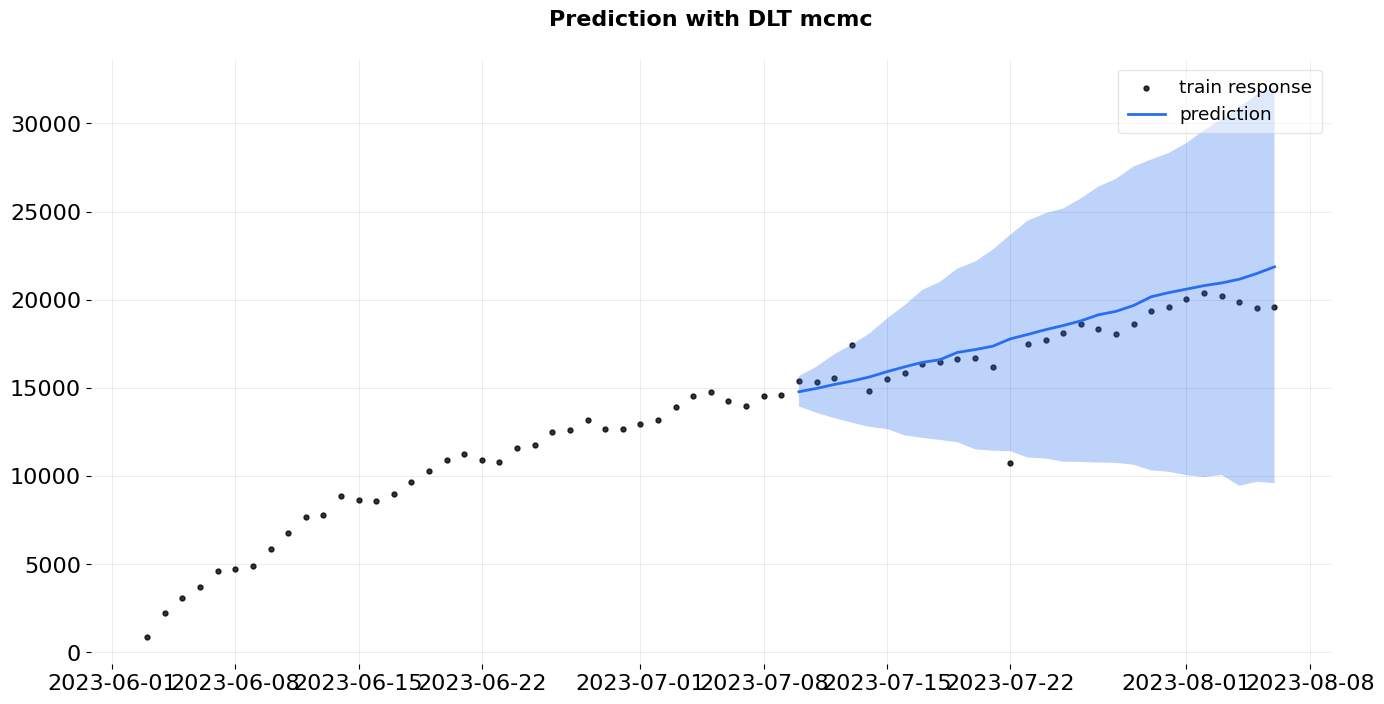

In [385]:
dlt_mcmc = DLT(seasonality=7*3, 
               response_col="users", 
               date_col="date", 
               estimator='stan-mcmc', 
               num_warmup=3000, 
               num_sample=1000) 

dlt_mcmc.fit(dau_train)
predict_mcmc = dlt_mcmc.predict(dau_test,
                               decompose=True)

_ = plot_predicted_data(dau_df, predict_mcmc, "date", "users", title='Prediction with DLT mcmc')

2023-08-07 13:04:28 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 750 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

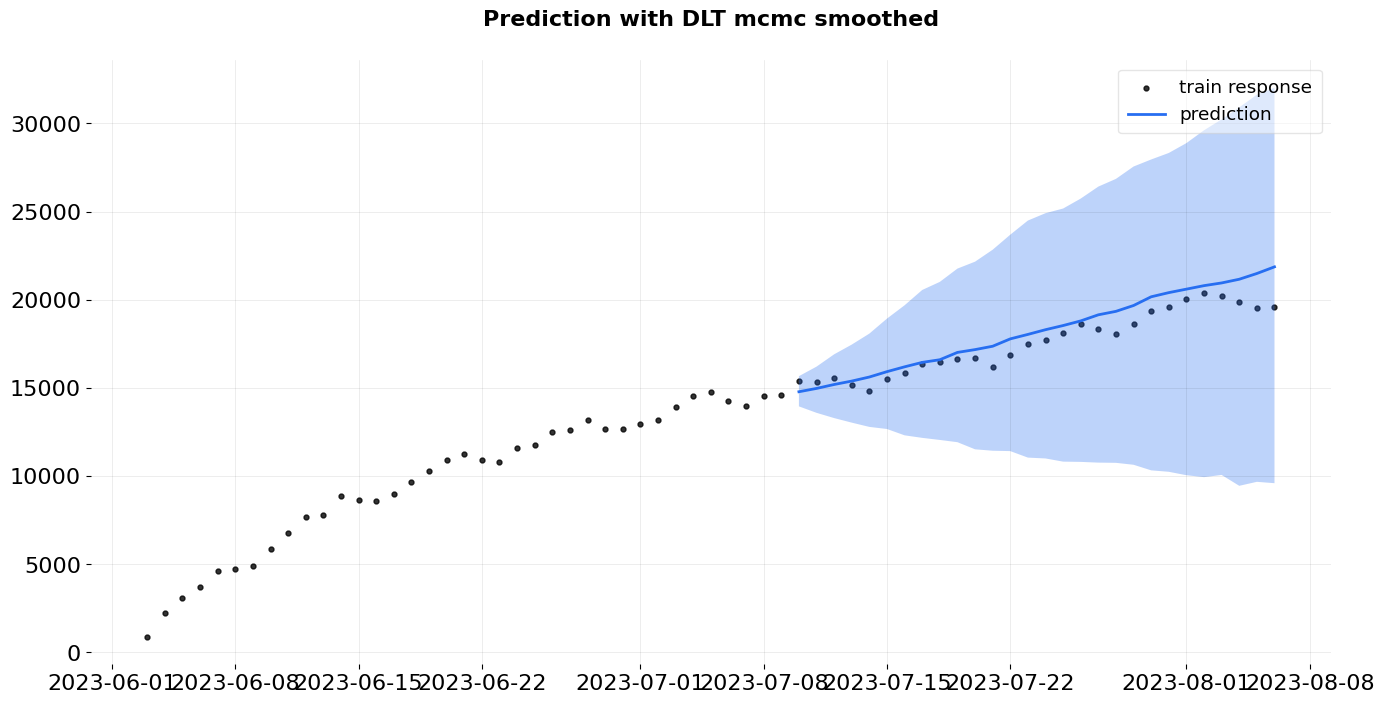

In [386]:
dlt_smooth_mcmc = DLT(seasonality=7*3, 
               response_col="users", 
               date_col="date", 
               estimator='stan-mcmc', 
               num_warmup=3000, 
               num_sample=1000) 

dlt_smooth_mcmc.fit(dau_smooth_train)
predict_smooth_mcmc = dlt_smooth_mcmc.predict(dau_smooth_test,
                               decompose=True)

_ = plot_predicted_data(dau_smooth, predict_smooth_mcmc, "date", "users", title='Prediction with DLT mcmc smoothed')

2023-08-07 13:04:39 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following fa

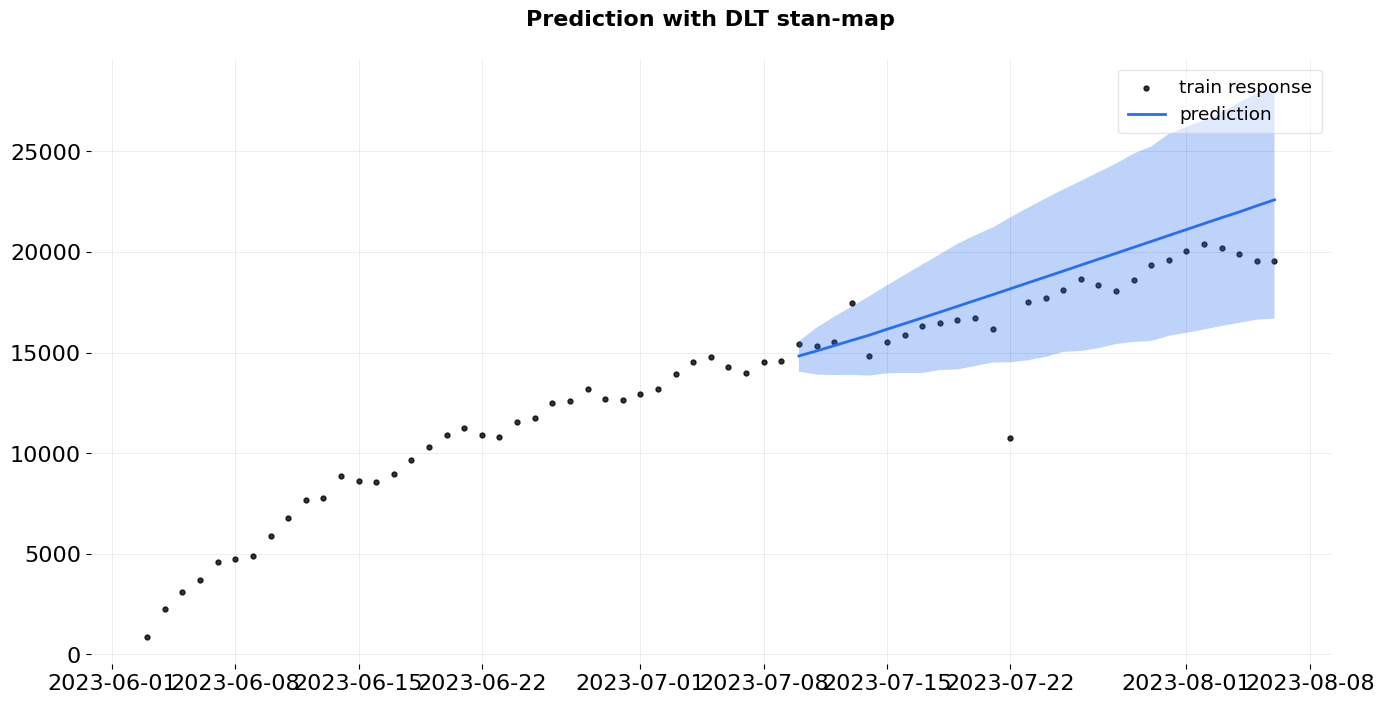

In [387]:
dlt = DLT(response_col="users", 
          date_col="date", 
          seasonality=7*3, 
          estimator="stan-map", 
          n_bootstrap_draws=2000) 

dlt.fit(dau_train)
#future_df = dlt.make_future_df(periods=7*4)
predict_dlt = dlt.predict(df=dau_test,
                         decompose=True)
_ = plot_predicted_data(dau_df, predict_dlt, "date", 'users', title='Prediction with DLT stan-map')

2023-08-07 13:04:43 - orbit - INFO - Optimizing (PyStan) with algorithm: LBFGS.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following fa

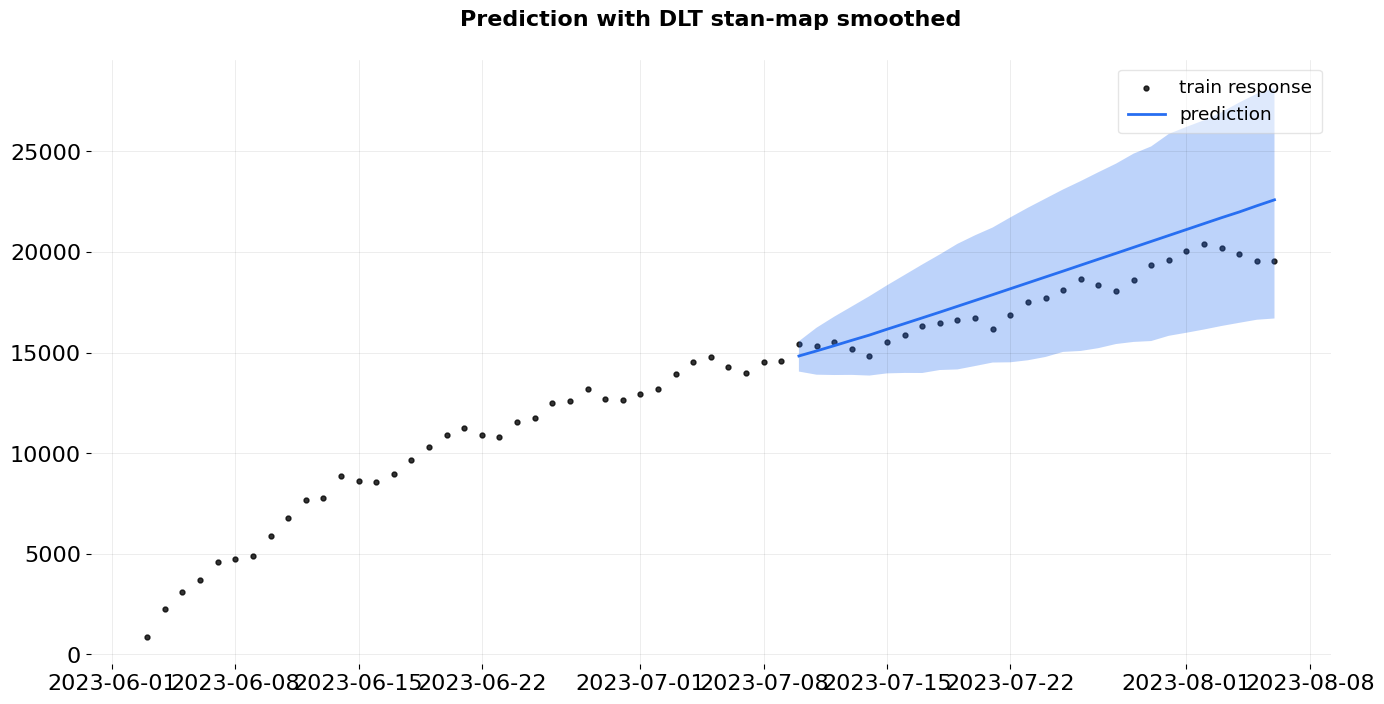

In [388]:
dlt_smooth = DLT(response_col="users", 
          date_col="date", 
          seasonality=7*3, 
          estimator="stan-map", 
          n_bootstrap_draws=2000) 

dlt_smooth.fit(dau_smooth_train)
predict_dlt_smooth = dlt_smooth.predict(df=dau_smooth_test,
                                         decompose=True)
_ = plot_predicted_data(dau_smooth, predict_dlt_smooth, "date", 'users', title='Prediction with DLT stan-map smoothed')

In [389]:
print(f"RMSE map: {rmsse(dau_test.users.values, predict_dlt.prediction.values, dau_train.users.values)}")
print(f"RMSE map smoothed: {rmsse(dau_smooth_test.users.values, predict_dlt_smooth.prediction.values, dau_smooth_train.users.values)}")
print(f"RMSE mcmc smoothed: {rmsse(dau_smooth_test.users.values, predict_smooth_mcmc.prediction.values, dau_smooth_train.users.values)}")
print(f"RMSE mcmc: {rmsse(dau_test.users.values, predict_mcmc.prediction.values, dau_train.users.values)}")

RMSE map: 1.0642606848382736
RMSE map smoothed: 3.207152958776671
RMSE mcmc smoothed: 2.1389993653264283
RMSE mcmc: 0.8957696864614271


* С сезонностью 3 недели минимальную ошибку 0,89 дает модель mcmc. Ее прогноз хорошо ложится на тестовые данные, правда доверительный интервал довольно широк. Прогноз на будущий месяц будем строить этой моделью.

## Прогноз на месяц вперед

### Прогноз с сезонностью 3 недели:

2023-08-07 13:39:10 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 750 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

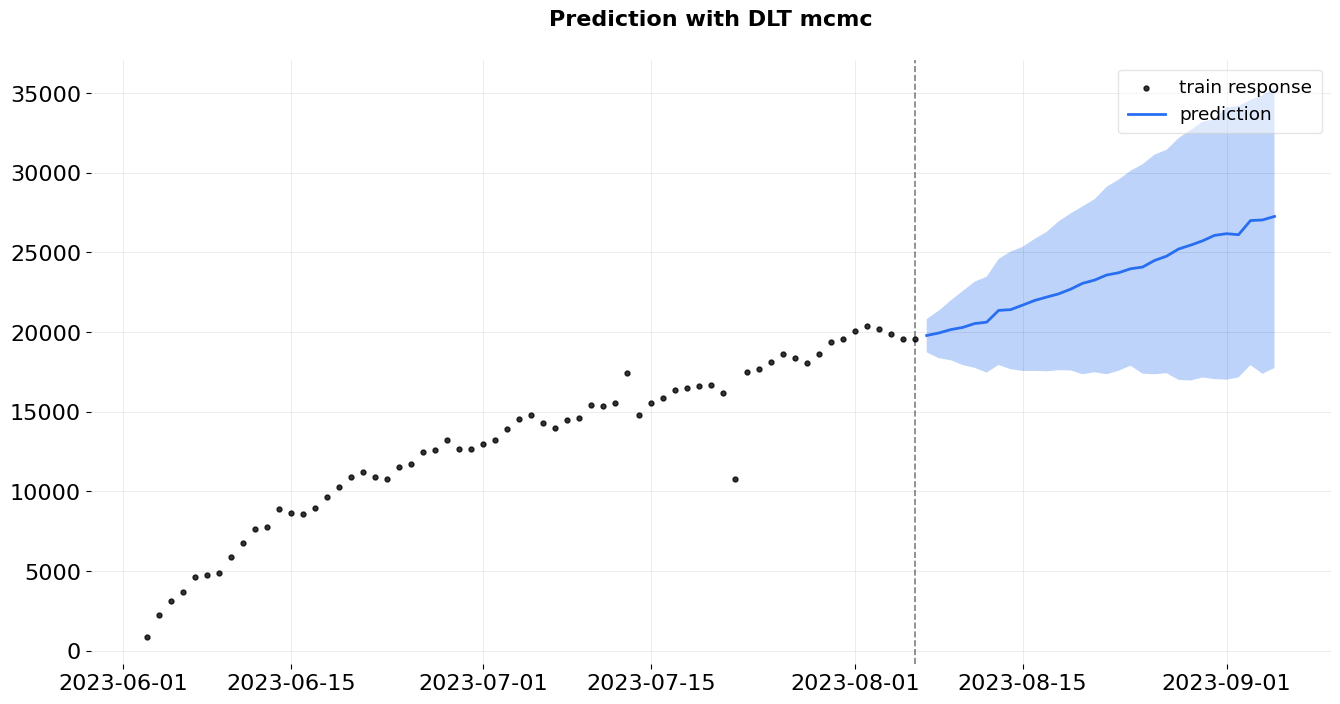

In [400]:
dlt_mcmc = DLT(seasonality=7*3, 
               response_col="users", 
               date_col="date", 
               estimator='stan-mcmc', 
               num_warmup=3000, 
               num_sample=1000) 

dlt_mcmc.fit(dau_df)

future_df = dlt_mcmc.make_future_df(periods=30)
predict_mcmc = dlt_mcmc.predict(future_df,
                                decompose=True)

_ = plot_predicted_data(dau_df, predict_mcmc, "date", "users", title='Prediction with DLT mcmc')

In [402]:
predict_mcmc.iloc[29]

date              2023-09-05 00:00:00
prediction_5             17751.942929
prediction               27262.247785
prediction_95            35340.780977
trend_5                  17758.464646
trend                    27258.432074
trend_95                 35339.540397
seasonality_5              -37.494388
seasonality                  3.143834
seasonality_95             111.517273
regression_5                      0.0
regression                        0.0
regression_95                     0.0
Name: 29, dtype: object

### Прогноз с сезонностью 1 неделя:

2023-08-07 13:39:42 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 750 and samples(per chain): 250.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

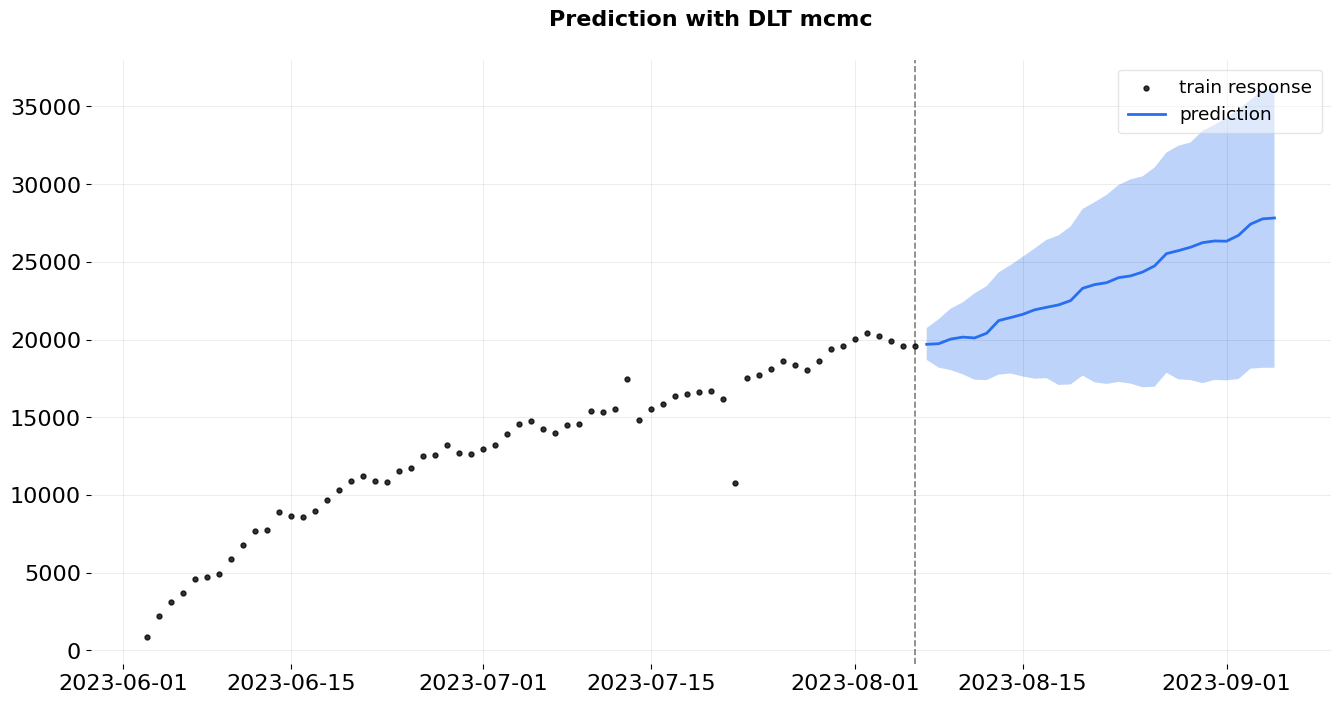

In [403]:
dlt_mcmc = DLT(seasonality=7, 
               response_col="users", 
               date_col="date", 
               estimator='stan-mcmc', 
               num_warmup=3000, 
               num_sample=1000) 

dlt_mcmc.fit(dau_df)

future_df = dlt_mcmc.make_future_df(periods=30)
predict_mcmc = dlt_mcmc.predict(future_df,
                                decompose=True)

_ = plot_predicted_data(dau_df, predict_mcmc, "date", "users", title='Prediction with DLT mcmc')

In [404]:
predict_mcmc.iloc[29]

date              2023-09-05 00:00:00
prediction_5             18186.805064
prediction               27819.915439
prediction_95            36198.385276
trend_5                  18189.289121
trend                    27790.006678
trend_95                 36180.891822
seasonality_5              -61.960396
seasonality                 13.937587
seasonality_95             254.658584
regression_5                      0.0
regression                        0.0
regression_95                     0.0
Name: 29, dtype: object

## Заключение
К концу следующего месяца количество активных пользователей в день предположительно достигнет 27000-28000, следовательно нагрузка на сервера возрастет примерно на 35%, и стоит увеличить их мощность.